# Weather Type Classification
## Tentang Dataset
Dataset ini mencakup berbagai fitur yang berhubungan dengan cuaca dan mengkategorikan cuaca ke dalam empat jenis: `Rainy`, `Sunny`, `Cloudy`, dan `Snowy`.
<figure>
  <img src="https://scied.ucar.edu/sites/default/files/media/images/weather_0.jpg" alt="Weather image" width="600"/>
  <figcaption>Diagram illustrating key elements of weather processes, from NCAR..</figcaption>
</figure>


Dataset source: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df_weather = pd.read_csv('dataset/weather.csv')
df_weather.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Exploratory Data Analysis (EDA)

In [3]:
cat_cols = [var for var in df_weather.columns if df_weather[var].dtypes == 'object']
cat_cols

['Cloud Cover', 'Season', 'Location', 'Weather Type']

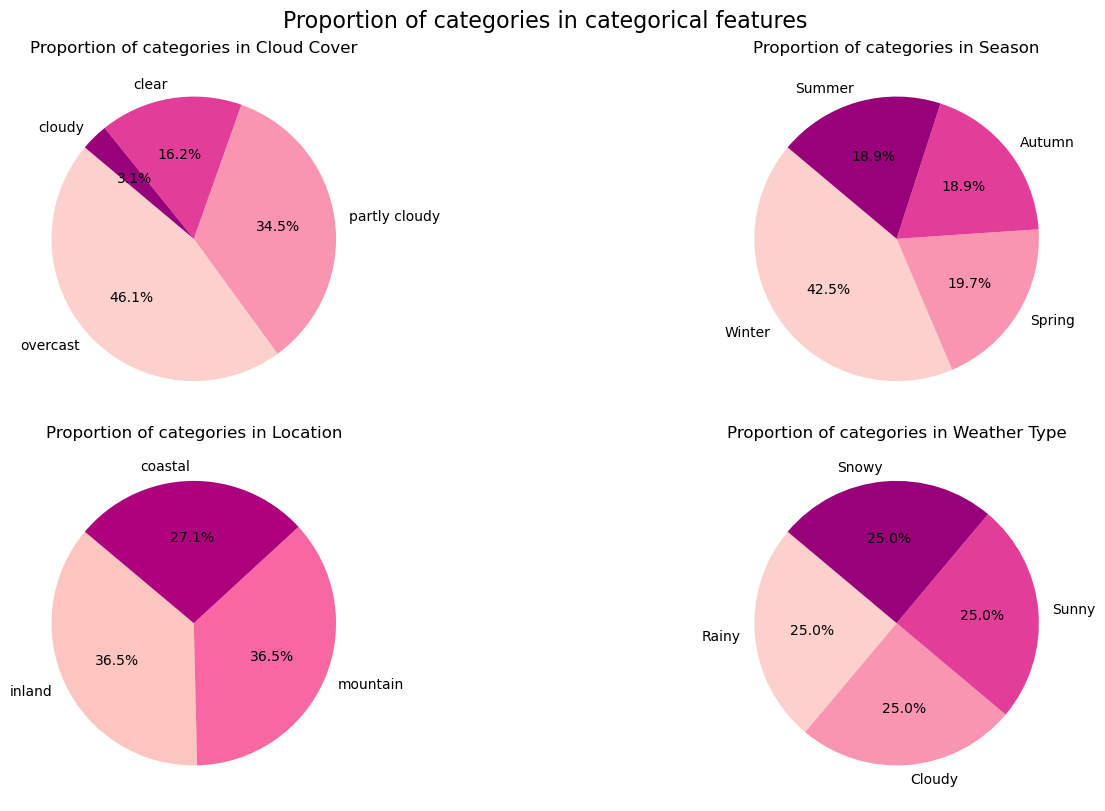

In [4]:
n = len(cat_cols)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), constrained_layout=True)

axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    counts = df_weather[col].value_counts()

    colors = sns.color_palette('RdPu', n_colors=len(counts))

    # Plot
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(f'Proportion of categories in {col}')

# hide for unused subplots
for ax in axes[len(cat_cols):]:
    ax.axis('off')

fig.suptitle('Proportion of categories in categorical features', fontsize=16)
plt.show()

Distribution Analysis

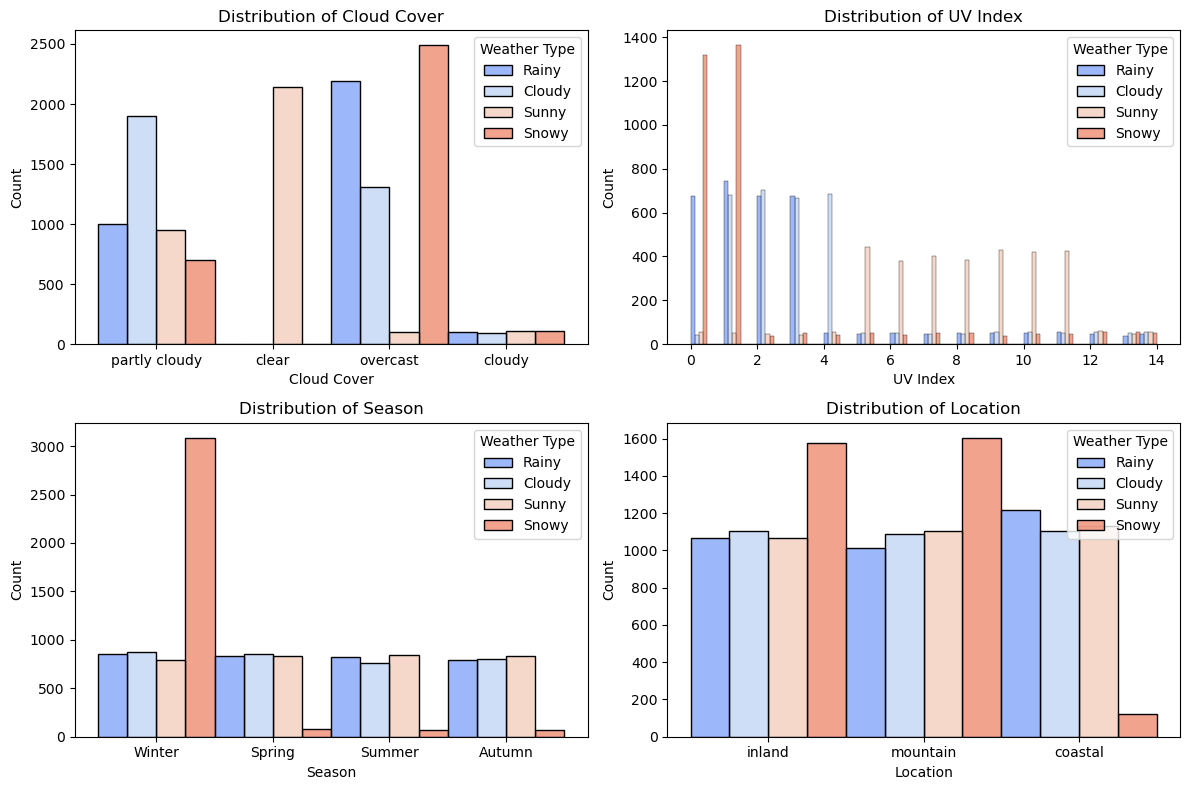

In [5]:
columns_to_plot = ['Cloud Cover', 'UV Index', 'Season', 'Location']

num_cols = len(columns_to_plot)
num_rows = (num_cols + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(x=df_weather[col], hue=df_weather["Weather Type"], multiple='dodge', palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# turn off axes for extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Conclusion**:

- **Cloud Cover**: Cloud cover conditions greatly influence the type of weather, with sunny weather tending to occur in clearer skies and rainy or cloudy weather occurring in cloudy conditions.

- **UV Index**: UV Index shows how strong the UV radiation from the sun is. When the weather is sunny, sunlight is not blocked, so the UV index tends to be higher. Conversely, when the weather is rainy, cloudy, or snowy, clouds and other particles in the atmosphere block sunlight, so the UV index becomes lower.
The assumptions as to why snow weather is highly distributed are as follows:
  - ***Altitude of location***: If snowy weather occurs in a highland area, the UV index can also be higher because the location is higher.
  - ***Reflection from snow***: Snow has the ability to reflect UV rays, so even though the weather may be cloudy, the existing UV rays that can be reflected from the surface of the snow can increase the UV index value.

- **Season**: Season influences the dominant type of weather, with snowy weather almost exclusively occurring in winter and sunny weather more common in summer.
- **Location**: Geographical location also has a significant influence, where mountainous areas experience snowy weather more often, while coastal areas experience more sunny and cloudy weather.

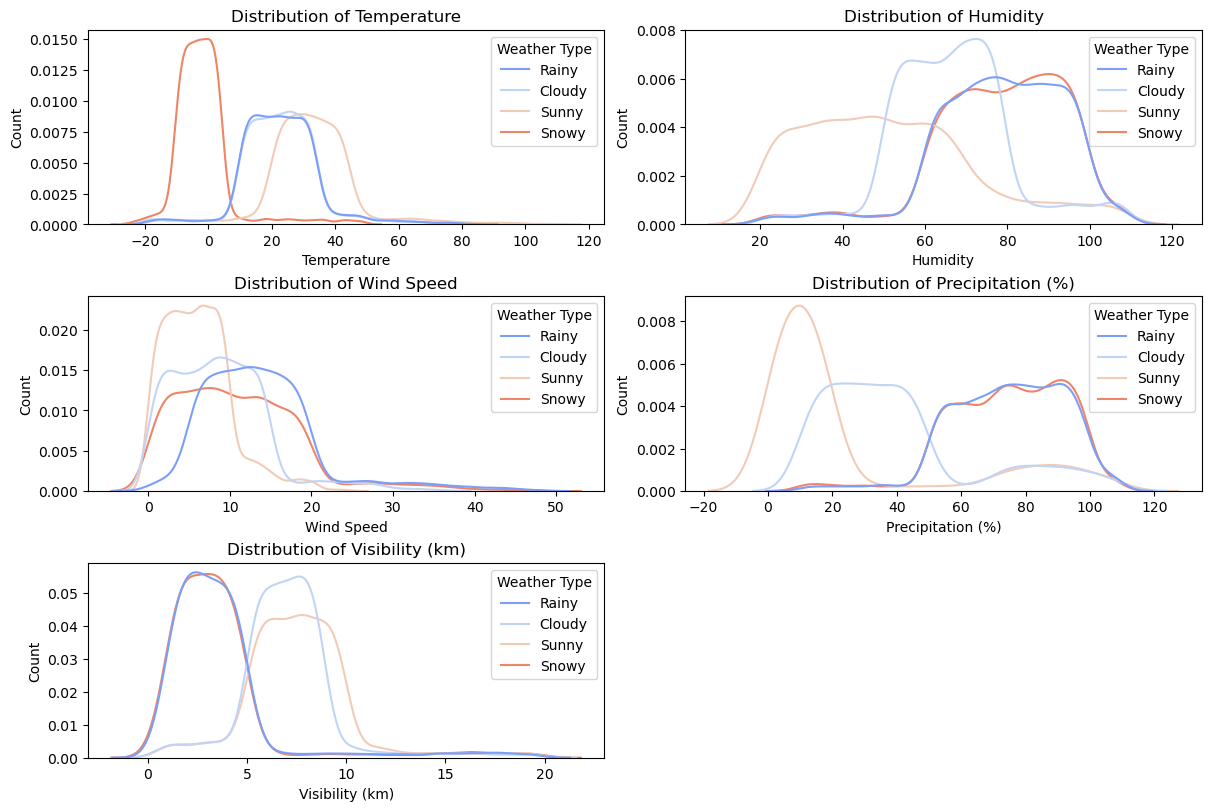

In [6]:
columns_to_plot = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Visibility (km)']

n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), constrained_layout=True)

axes = axes.flatten()

for ax, col in zip(axes, columns_to_plot):
    sns.kdeplot(x=df_weather[col], hue=df_weather['Weather Type'], palette='coolwarm', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])


plt.show()

**Conclusion**: <br>
- **Sunny weather**: tends to occur at higher temperatures with lower humidity and rainfall and the best visibility.

- **Rainy and snowy weather**: indicates high humidity, significant precipitation, and lower visibility, with temperatures related to the characteristics of each.

- **Cloudy weather**: shows a more varied distribution of all features, reflecting more diverse weather conditions.

Feature Correlation

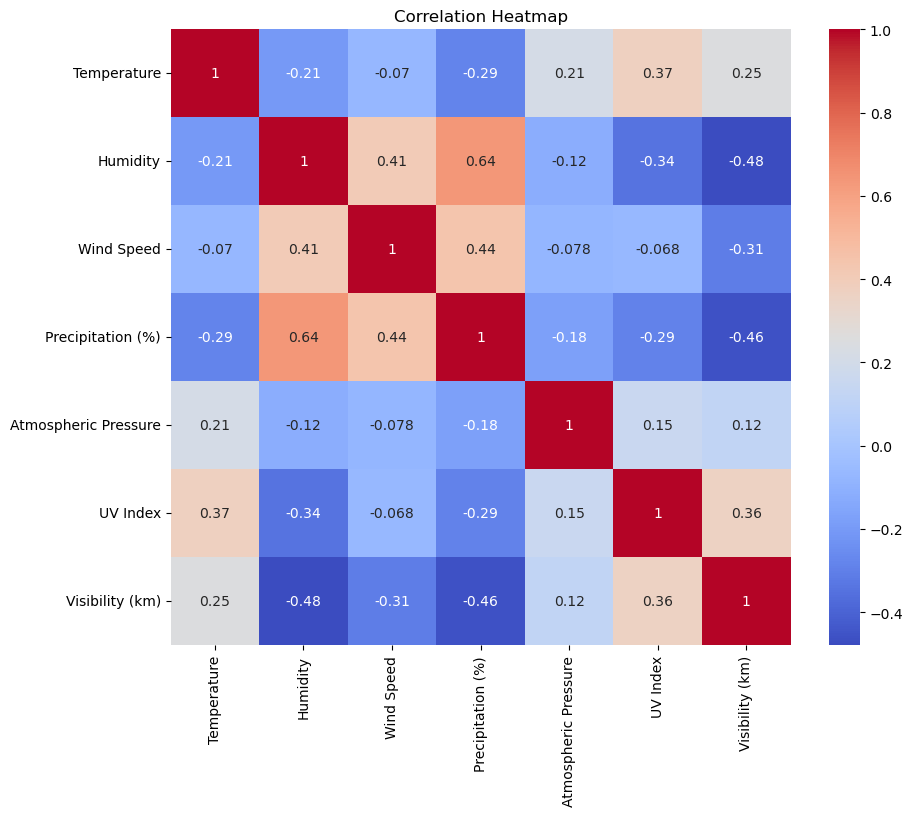

In [7]:
cols_to_use = df_weather.describe().columns

plt.figure(figsize=(10,8))

correlation_matrix = df_weather[cols_to_use].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Checking missing and duplicated values

In [8]:
print(f'There are {df_weather.isna().sum().sum()} missing values in the dataset')
print(f'There are {df_weather.duplicated().sum()} duplicate values in the dataset')

There are 0 missing values in the dataset
There are 0 duplicate values in the dataset


In [9]:
numeric_columns = df_weather.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')

In [10]:
# for col in numeric_columns:
#     plt.figure(figsize=(6, 6))
#     plt.boxplot(df_weather[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

We're not going to do anything with the outliers because we wanna treat them the same as the rest of the data.

Data Preprocessing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_weather.drop('Weather Type', axis=1),
    df_weather['Weather Type'],
    test_size=0.3,
    random_state=0
)

X_train.shape, y_train.shape

((9240, 10), (9240,))

Variables Encoding

In [12]:
# Categorical features
encoder = OrdinalEncoder(
    variables=['Cloud Cover', 'Season', 'Location'],
    encoding_method='arbitrary'
)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [13]:
encoder.encoder_dict_

{'Cloud Cover': {'overcast': 0, 'partly cloudy': 1, 'clear': 2, 'cloudy': 3},
 'Season': {'Winter': 0, 'Summer': 1, 'Spring': 2, 'Autumn': 3},
 'Location': {'mountain': 0, 'inland': 1, 'coastal': 2}}

In [14]:
def weather_to_num(weather):
    weather_map = {
        'Cloudy': 0,
        'Rainy': 1,
        'Snowy': 2,
        'Sunny': 3
    }
    return weather_map.get(weather, -1)  # Return -1 if weather is not in the map

y_train = pd.Series(y_train)  # Uncomment if y_train is not already a pandas Series
y_test = pd.Series(y_test)    # Uncomment if y_test is not already a pandas Series

y_train = y_train.apply(weather_to_num)
y_test = y_test.apply(weather_to_num)

In [15]:
y_train.value_counts()

Weather Type
3    2330
0    2308
1    2301
2    2301
Name: count, dtype: int64

Feature Scaling:
We'll use `MinMaxScaler` to scale the data.

In [16]:
# feature scale numeric cols
mms = MinMaxScaler()
cols = numeric_columns
X_train[cols] = mms.fit_transform(X_train[cols])
X_test[cols] = mms.transform(X_test[cols])

In [17]:
X_train

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
10918,0.373134,0.584270,0.309278,0.798165,0,0.479955,0.071429,0,0.100,0
1361,0.679104,0.977528,0.268041,1.000000,1,0.537621,0.428571,1,0.350,0
6260,0.358209,0.887640,0.123711,0.724771,1,0.557578,0.785714,0,0.425,0
10848,0.201493,0.842697,0.030928,0.678899,0,0.486072,0.857143,0,0.000,0
4014,0.134328,0.808989,0.185567,0.559633,0,0.489206,0.071429,0,0.100,1
...,...,...,...,...,...,...,...,...,...,...
13123,0.194030,0.662921,0.051546,0.761468,0,0.500313,0.071429,0,0.125,1
3264,0.156716,0.505618,0.154639,0.532110,1,0.474966,0.071429,0,0.225,1
9845,0.410448,0.438202,0.175258,0.045872,2,0.530676,0.428571,2,0.300,2
10799,0.283582,0.157303,0.082474,0.816514,1,0.334712,0.571429,0,0.275,2


Modelling

In [18]:
def model_train_2(model):
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on both training and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print('-'*50)
    print('Training set performance')
    print()
    print(f"Accuracy: {accuracy_score(y_train, y_preds_train)}")
    print(f"Precision: {precision_score(y_train, y_preds_train, average='weighted')}")
    print(f"Recall: {recall_score(y_train, y_preds_train, average='weighted')}")
    print(f"F1 Score: {f1_score(y_train, y_preds_train, average='weighted')}")
    print(f'ROC-AUC Score: {roc_auc_score(y_train, model.predict_proba(X_train), multi_class="ovr")}')
    print('-'*50)
    
    print('Test set performance')
    print()
    print(f"Accuracy: {accuracy_score(y_test, y_preds_test)}")
    print(f"Precision: {precision_score(y_test, y_preds_test, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_preds_test, average='weighted')}")
    print(f"F1 Score: {f1_score(y_test, y_preds_test, average='weighted')}")
    print('-'*50)

    # Plot the confusion matrix for test set only
    cm = confusion_matrix(y_test, y_preds_test)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix (Test Set): {model}')
    plt.show()

--------------------------------------------------
Training set performance

Accuracy: 0.9928571428571429
Precision: 0.99288121564613
Recall: 0.9928571428571429
F1 Score: 0.9928620737576983
ROC-AUC Score: 0.9997147792944302
--------------------------------------------------
Test set performance

Accuracy: 0.9237373737373737
Precision: 0.9239401084622447
Recall: 0.9237373737373737
F1 Score: 0.9236933927583136
--------------------------------------------------


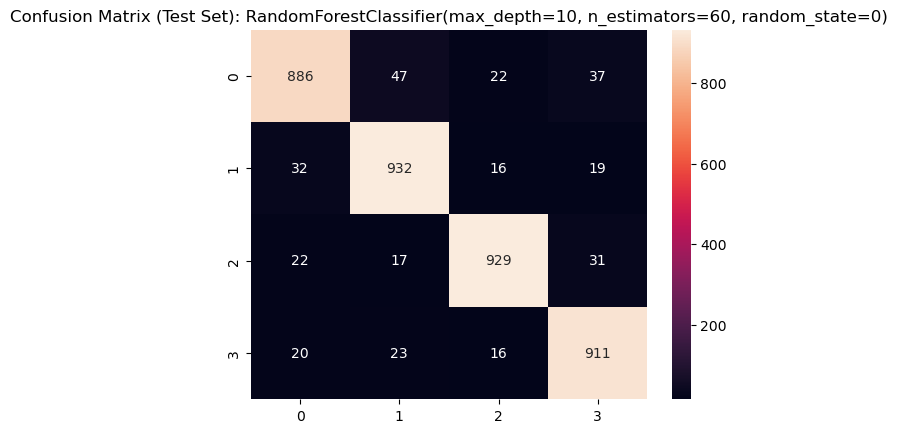

In [19]:
model_rf = RandomForestClassifier(max_depth=10, n_estimators=60, random_state=0)
model_train_2(model_rf)


--------------------------------------------------
Training set performance

Accuracy: 0.9994588744588745
Precision: 0.9994600477579664
Recall: 0.9994588744588745
F1 Score: 0.9994588747136072
ROC-AUC Score: 0.9999995148667395
--------------------------------------------------
Test set performance

Accuracy: 0.9237373737373737
Precision: 0.923858392943347
Recall: 0.9237373737373737
F1 Score: 0.923675050723654
--------------------------------------------------


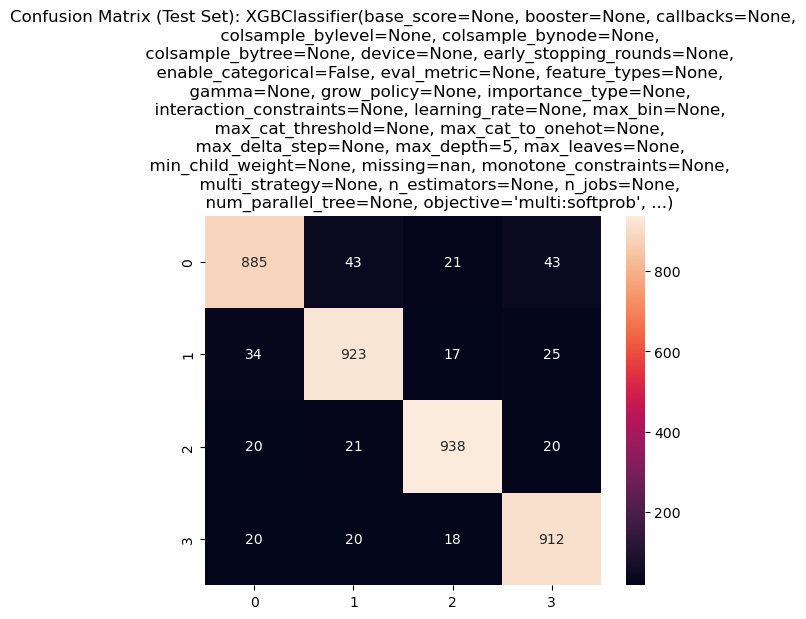

In [20]:
model_xgb = xgb.XGBClassifier(max_depth=5, random_state=0)
model_train_2(model_xgb)

In [21]:
# add model performance metric into new dataframe
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Define the metrics for each model
rf_metrics = pd.DataFrame([{
    'Model': 'Random Forest',
    'Accuracy': 0.9237373737373737,
    'Precision': 0.9239401084622447,
    'Recall': 0.9237373737373737,
    'F1-Score': 0.9236933927583136
}])

xgb_metrics = pd.DataFrame([{
    'Model': 'XGBoost',
    'Accuracy': 0.9237373737373737,
    'Precision': 0.923858392943347,
    'Recall': 0.9237373737373737,
    'F1-Score': 0.923675050723654
}])

model_performance = pd.concat([
    rf_metrics,
    xgb_metrics
], ignore_index=True)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow; color: black' if v else '' for v in is_max]

model_performance_metric = model_performance.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

model_performance_metric

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.923737,0.923940,0.923737,0.923693
1,XGBoost,0.923737,0.923858,0.923737,0.923675


Saving our random forest model

In [22]:
import pickle as pkl

pickle_out = open('classifier.pkl', mode='wb')
pkl.dump(model_rf, pickle_out)
pickle_out.close()

In [23]:
with open('scaler.pkl', 'wb') as f:
    pkl.dump(mms, f)

In [24]:
df_weather.sample(5, random_state=5)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
13168,44.0,45,7.0,28.0,partly cloudy,894.65,5,Spring,11.5,inland,Sunny
10016,28.0,66,3.0,26.0,partly cloudy,1006.05,4,Winter,5.5,coastal,Cloudy
4185,-5.0,85,10.5,52.0,overcast,990.69,0,Winter,2.0,mountain,Snowy
12095,2.0,99,4.5,62.0,overcast,992.81,0,Winter,3.0,inland,Snowy
4826,22.0,87,18.5,54.0,overcast,1003.13,1,Winter,2.0,inland,Rainy
